In [54]:
import h5py # for working with HDF5 (Hierarchical Data Format) files
import numpy as np
import sklearn.svm
import matplotlib.pyplot as plt
import pandas as pd
import os
from V3.load_calcium_video import load_video_data, load_one_video
from V3.align_behavior_to_calcium import align_files_old_labels, align_files_new_labels
from V3.class_balance import check_class_imbalance_old, check_class_imbalance_new 
from V3.preprocessing_model import model_preprocessing
from V3.save_model_info import save_training_info
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.svm import LinearSVC

In [2]:
comment = "k-fold-cross validation, multiple videos, new labels"

experiment_ID = '4-BPSVM'

data_file = 'Animal3learnday8, Animal3Learnday9, Animal3Learnday10'

experiment_name = str(data_file)+"_"+str(experiment_ID)

train_test_split_strategy = "k-fold"

name = 'BPSVM'

model_version = str(name)+'_1'

# Which labels am I using? Old or New?
labels_type = 'new' # or 'old'

# Shuffle data? This to find chance performance
shuffled_labels = False

# Which architecture am I using 
architecture_type = 'standard' # or 'old'

# will you merge labels or not?
merge_labels = False

# Am I using one or multiple videos for training?
multiple_videos = True 

# store the initiation variables:
%store experiment_ID
%store data_file
%store experiment_name
%store train_test_split_strategy
%store name
%store model_version
%store labels_type
%store merge_labels
%store shuffled_labels
%store architecture_type
%store multiple_videos

Stored 'experiment_ID' (str)
Stored 'data_file' (str)
Stored 'experiment_name' (str)
Stored 'train_test_split_strategy' (str)
Stored 'name' (str)
Stored 'model_version' (str)
Stored 'labels_type' (str)
Stored 'merge_labels' (bool)
Stored 'shuffled_labels' (bool)
Stored 'architecture_type' (str)
Stored 'multiple_videos' (bool)


In [3]:
# # Define the name of the output directory
# output_dir = "output-svm"

# # Check if the output directory already exists
# if not os.path.exists(output_dir):
#     # Create the output directory
#     os.mkdir(output_dir)

#     # Create the balance, accuracy, loss, and cm directories inside the output directory
#     os.mkdir(os.path.join(output_dir, "balance"))
#     os.mkdir(os.path.join(output_dir, "accuracy"))
#     os.mkdir(os.path.join(output_dir, "loss"))
#     os.mkdir(os.path.join(output_dir, "cm"))
#     os.mkdir(os.path.join(output_dir, "architecture"))
#     os.mkdir(os.path.join(output_dir, "pickles"))
# else:
#     print(f"The directory {output_dir} already exists.")

# create output directory
output_dir = str(experiment_ID)+'_output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
    
%store output_dir

Stored 'output_dir' (str)


### Loading Calcium Videos

In [4]:
video_name_list = []
video_data_list = []

if multiple_videos == True:
    # paths to videos
    video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]
    # load the CSV file with the FOV information
    fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')
    images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

else:
    # change the path if you're using another video other than animal3learnday11
    video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_174510_animal2learnday11.nwb"]    
    # video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.nwb"]
    images = load_one_video(video_path, video_name_list, video_data_list)


20211025_184906_animal3learnday8.nwb recording_20211025_184906-PP-BP-MC
20211025_184906_animal3learnday8.nwb is cropped
(24479, 356, 398)
20211026_142935_animal3learnday9.nwb recording_20211026_142935-PP-BP-MC
20211026_142935_animal3learnday9.nwb is cropped
(24434, 356, 398)
20211027_165052_animal3learnday10.nwb recording_20211027_165052-PP-BP_001-MC
20211027_165052_animal3learnday10.nwb is cropped
(24456, 356, 398)
Concatenated video shape: (73369, 356, 398)


In [5]:
images[0].shape

(356, 398)

In [6]:
# Check if the video has been loaded correctly
images[:1]

array([[[175, 172, 164, ..., 157, 163, 172],
        [167, 167, 168, ..., 164, 158, 166],
        [171, 170, 167, ..., 161, 155, 160],
        ...,
        [172, 156, 151, ..., 171, 166, 167],
        [163, 162, 157, ..., 167, 163, 170],
        [146, 162, 160, ..., 161, 161, 160]]], dtype=int16)

In [7]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  73369  and the frame dimensions (height x width) are:  356 X 398


### Loading Calcium Traces

In [8]:
path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/animal3.h5"

In [9]:
# manually change from which videos you want to extract calcium traces
list_of_traces = []

if multiple_videos == True:
    with (h5py.File(path, 'r')) as f:
        traces_8 = np.array(f['traces/animal3learnday8/deconvolved'])
        list_of_traces.append(traces_8)
        traces_9 = np.array(f['traces/animal3learnday9/deconvolved'])
        list_of_traces.append(traces_9)
        traces_10 = np.array(f['traces/animal3learnday10/deconvolved'])
        list_of_traces.append(traces_10)
else:
    with (h5py.File(path, 'r')) as f:
        traces = np.array(f['traces/animal3learnday11/deconvolved'])
        # list_of_traces.append(traces_11)

In [10]:
traces = np.concatenate(list_of_traces, axis=1)
print("Concatenated traces shape:", traces.shape)

Concatenated traces shape: (110, 73369)


In [11]:
traces

array([[1049.434 , 1057.2839, 1015.9747, ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

### Load Labels

In [12]:
if multiple_videos == True:
    num_of_videos = 3
else:
    num_of_videos = 1

In [13]:
if multiple_videos == True:
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]
else:
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T18_13_23.csv"]

    
    
    
if multiple_videos == True:

    if labels_type == 'old':


        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)
    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)

        
else:
    if labels_type == 'old':
        behavior_paths = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.h5"
        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)


    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)


In [14]:
# behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

In [15]:
df_new_annotations_check

,state_id,state_name
0,3,moving
1,3,moving
2,3,moving
3,3,moving
4,3,moving
...,...,...
24451,0,grooming
24452,0,grooming
24453,1,immobile
24454,1,immobile


In [16]:
df_new_annotations

0        3
1        3
2        3
3        3
4        3
        ..
24451    0
24452    0
24453    1
24454    1
24455    1
Name: state_id, Length: 73369, dtype: object

In [17]:
# df_new_annotations = align_files(bonsai_paths, behavior_paths, num_of_videos)
# df_new_annotations = align_files(bonsai_paths, num_of_videos, h5_path)

In [18]:
# df_new_annotations = df_new_annotations.loc[:, 'state_id']    

In [19]:
df_new_annotations = df_new_annotations.reset_index(drop=True)
# df_new_annotations = df_new_annotations.reset_index()

In [20]:
df_new_annotations

0        3
1        3
2        3
3        3
4        3
        ..
73364    0
73365    0
73366    1
73367    1
73368    1
Name: state_id, Length: 73369, dtype: object

In [21]:
df_new_annotations_unique = df_new_annotations.unique()

In [22]:
df_new_annotations_unique

array([3, 4, 1, 0, 2, 5], dtype=object)

In [23]:
no_of_labels = len(df_new_annotations_unique)

In [24]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/"+str(output_dir)+"/balance"

In [25]:
data_file

'Animal3learnday8, Animal3Learnday9, Animal3Learnday10'

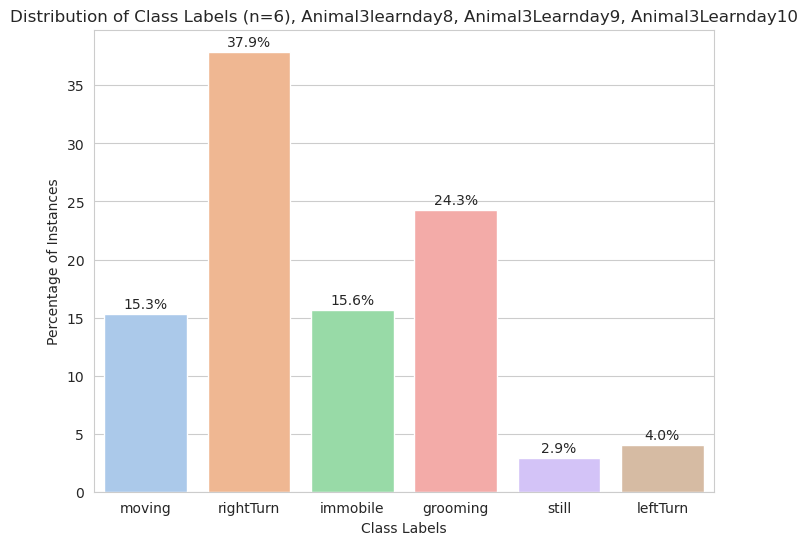

In [26]:
if labels_type == 'old':
    class_counts, total_counts = check_class_imbalance_old(df_new_annotations, experiment_ID, save_dir)
else:
    class_counts, total_counts = check_class_imbalance_new(df_new_annotations, experiment_ID, save_dir, df_new_annotations_unique, df_new_annotations_check, no_of_labels, data_file)

In [27]:
labels = df_new_annotations.values

In [28]:
labels

array([3, 3, 3, ..., 1, 1, 1], dtype=object)

In [29]:
labels.shape

(73369,)

In [30]:
type(labels)

numpy.ndarray

In [31]:
# data verification
# plt.plot(traces[50])

In [32]:
type(traces[50])

numpy.ndarray

In [33]:
traces.shape

(110, 73369)

In [34]:
num_classes = len(df_new_annotations_unique)

In [35]:
num_classes

6

In [36]:
# traces, labels, num_classes = model_preprocessing(traces, labels, df_new_annotations_unique)

In [37]:
# labels

In [38]:
labels = labels.astype(np.int32)

## Perform k-fold cross validation for the SVM

In [39]:
mySVC = sklearn.svm.LinearSVC()

### Run the SVM for the regular and shuffled labels with K-Fold CV

In [41]:
# Create and fit the classifier
mySVC = LinearSVC()
mySVC.fit(traces.T, labels)

# Perform cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits)
y_pred = cross_val_predict(mySVC, traces.T, labels, cv=kf)
y_pred_prob = cross_val_predict(mySVC, traces.T, labels, cv=kf, method='decision_function')

# Shuffle the labels
shuffled_labels = np.roll(labels, 15000, axis=0)

# Calculate accuracy and loss for each fold
accuracies = []
losses = []
cm_avg = []
shuffled_accuracies = []
shuffled_losses = []
shuffled_cm_avg = []
f1_score_val_list = []
f1_score_val_list_shuffle = []

for train_index, test_index in kf.split(traces.T):
    X_train, X_test = traces.T[train_index], traces.T[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    shuffled_y_train, shuffled_y_test = shuffled_labels[train_index], shuffled_labels[test_index]
    
    mySVC.fit(X_train, y_train)
    y_pred_fold = mySVC.predict(X_test)
    y_pred_prob_fold = mySVC.decision_function(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    losses.append(log_loss(y_test, y_pred_prob_fold))
    cm = confusion_matrix(y_test, y_pred_fold)
    cm_avg.append(cm)
    
    # Find the f1 score
    f1_score_val = f1_score(y_test, y_pred_fold, average='micro')
    print("F1 score is: {:.3f}".format(f1_score_val))
    f1_score_val_list.append(f1_score_val)
    
    mySVC.fit(X_train, shuffled_y_train)
    shuffled_y_pred_fold = mySVC.predict(X_test)
    shuffled_y_pred_prob_fold = mySVC.decision_function(X_test)
    
    shuffled_accuracies.append(accuracy_score(y_test, shuffled_y_pred_fold))
    shuffled_losses.append(log_loss(y_test, shuffled_y_pred_prob_fold))
    shuffled_cm = confusion_matrix(y_test, shuffled_y_pred_fold)
    shuffled_cm_avg.append(shuffled_cm)
    
    # Find the f1 score for shuffled labels
    f1_score_val_shuffle = f1_score(y_test, shuffled_y_pred_fold, average='micro')
    print("F1 score is: {:.3f}".format(f1_score_val_shuffle))
    f1_score_val_list_shuffle.append(f1_score_val_shuffle)

In [42]:
mean_f1 = np.mean(f1_score_val_list)
mean_f1_shuffle = np.mean(f1_score_val_list_shuffle)
    
# Print results
print("Normal Accuracy:", accuracies)
print("Shuffled Accuracy:", shuffled_accuracies)
print("Normal Loss:", losses)
print("Shuffled Loss:", shuffled_losses)
print("Normal F1_score", mean_f1)
print("Shuffle F1_score", mean_f1_shuffle)

Normal Accuracy: [0.3733814910726455, 0.36261414747171866, 0.41208940984053427, 0.43478260869565216, 0.42765623935118924]
Shuffled Accuracy: [0.3064604061605561, 0.26332288401253917, 0.3257462178001908, 0.4024124301485621, 0.27915218428405913]
Normal Loss: [9.065439566714446, 8.426942291388878, 10.701678544613392, 11.489880182852032, 8.859625434033944]
Shuffled Loss: [7.8341113784538985, 9.494844635570614, 12.973150145616776, 11.415605477452313, 12.535101715831546]
Normal F1_score 0.402104779286348
Shuffle F1_score 0.31541882448118147


### Plot Everything

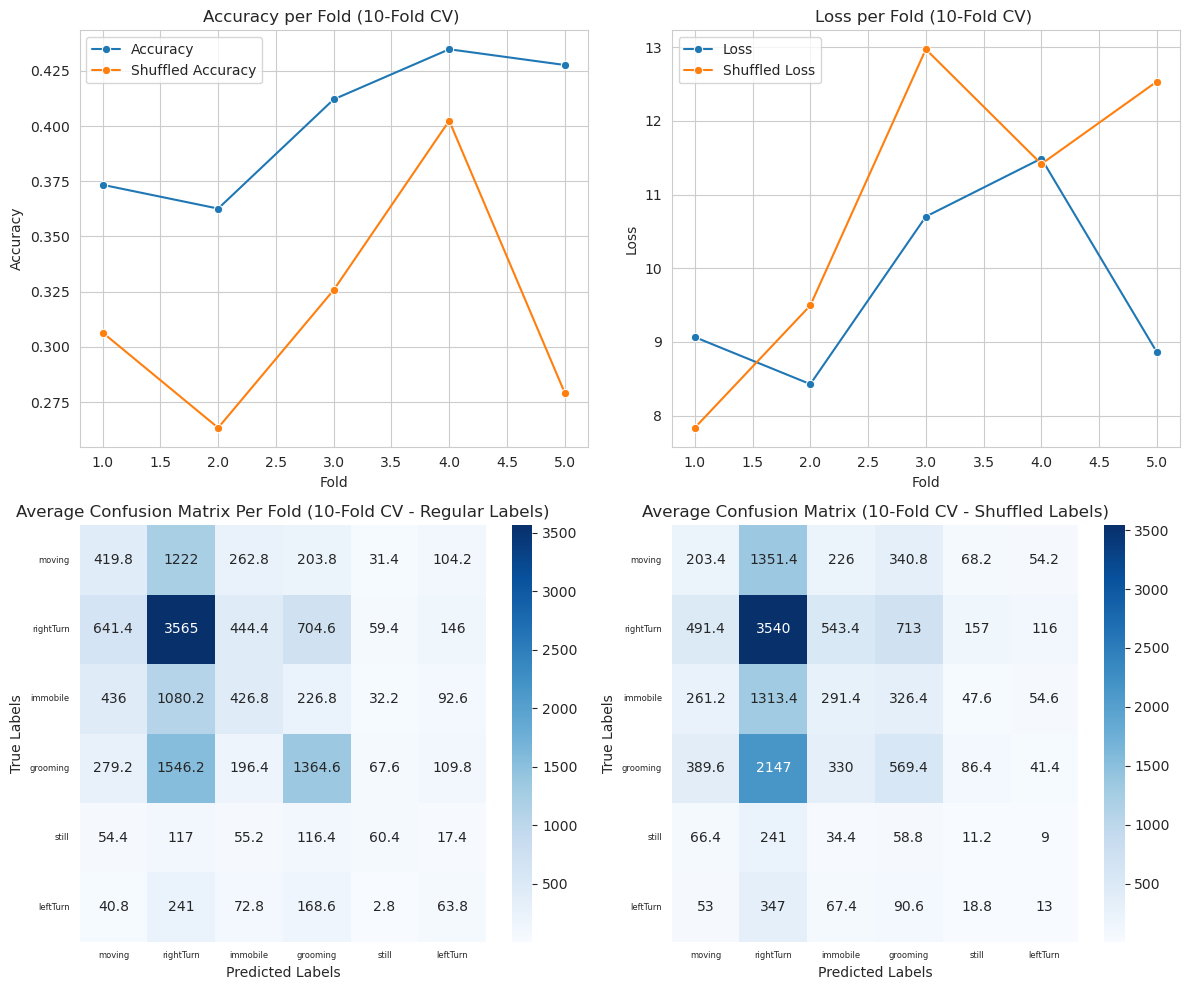

In [44]:
# Plotting
n_splits = 5

plt.figure(figsize=(12, 10))

# Accuracy and Shuffled Accuracy
plt.subplot(2, 2, 1)
sns.lineplot(x=np.arange(1, n_splits+1), y=accuracies, marker='o', label='Accuracy')
sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_accuracies, marker='o', label='Shuffled Accuracy')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Accuracy per Fold (10-Fold CV) ")
plt.legend()

# Loss and Shuffled Loss
plt.subplot(2, 2, 2)
sns.lineplot(x=np.arange(1, n_splits+1), y=losses, marker='o', label='Loss')
sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_losses, marker='o', label='Shuffled Loss')
plt.xlabel("Fold")
plt.ylabel("Loss")
plt.title("Loss per Fold (10-Fold CV) ")
plt.legend()

# Average Confusion Matrix for Regular Labels
plt.subplot(2, 2, 3)
train_labels_names = ['moving', 'rightTurn', 'immobile', 'grooming', 'still', 'leftTurn']
sns.heatmap(np.mean(cm_avg, axis=0), annot=True, cmap='Blues', fmt='g')
plt.title('Average Confusion Matrix Per Fold (10-Fold CV - Regular Labels)')
plt.xlabel('Predicted Labels')
plt.xticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, ha='center', fontsize=6)
plt.ylabel('True Labels')
plt.yticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, rotation=0, fontsize=6)

# Average Confusion Matrix for Shuffled Labels
plt.subplot(2, 2, 4)
sns.heatmap(np.mean(shuffled_cm_avg, axis=0), annot=True, cmap='Blues', fmt='g')
plt.title('Average Confusion Matrix (10-Fold CV - Shuffled Labels)')
plt.xlabel('Predicted Labels')
plt.xticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, ha='center', fontsize=6)
plt.ylabel('True Labels')
plt.yticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, rotation=0, fontsize=6)


save_SVM_plots = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/4-BPSVM_output/"
plt.savefig(save_SVM_plots+"/accuracy_loss_cm_regular_shuffled_labels.svg", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Save results in the folder to reproduce later if needed

In [45]:
# create pickles directory
dir_name_pickles = os.path.join(output_dir, 'results')
if not os.path.exists(dir_name_pickles):
    os.mkdir(dir_name_pickles)

# save pickle files
with open(os.path.join(dir_name_pickles, 'shuffled_accuracies.pkl'), 'wb') as f:
    pickle.dump(shuffled_accuracies, f)

with open(os.path.join(dir_name_pickles, 'losses.pkl'), 'wb') as f:
    pickle.dump(losses, f)

with open(os.path.join(dir_name_pickles, 'shuffled_losses.pkl'), 'wb') as f:
    pickle.dump(shuffled_losses, f)

with open(os.path.join(dir_name_pickles, 'train_labels_names.pkl'), 'wb') as f:
    pickle.dump(train_labels_names, f)
    
    
with open(os.path.join(dir_name_pickles, 'cm_avg.pkl'), 'wb') as f:
    pickle.dump(cm_avg, f)

with open(os.path.join(dir_name_pickles, 'shuffled_cm_avg.pkl'), 'wb') as f:
    pickle.dump(shuffled_cm_avg, f)

In [46]:
experiment_ID

'4-BPSVM'

In [47]:
data_file

'Animal3learnday8, Animal3Learnday9, Animal3Learnday10'

In [48]:
no_of_labels

6

In [49]:
output_dir

'4-BPSVM_output'

In [50]:
# f1_score_mean = np.mean(f1_score_val_list)
# f1_score_mean_shuffle = np.mean(f1_score_val_list_shuffle)

In [51]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/"+str(output_dir)

In [59]:
save_training_info(experiment_ID=experiment_ID,
                   data_file = data_file,
                   no_of_labels = no_of_labels,
                   comment=comment,
                   save_dir=save_dir,
                   f1_score_mean = mean_f1
                  )

Training info saved in csv file.


In [60]:
save_training_info(experiment_ID=experiment_ID+str("-shuffled"),
                   data_file = data_file,
                   no_of_labels = no_of_labels,
                   comment=comment,
                   save_dir=save_dir,
                   f1_score_mean = mean_f1_shuffle
                  )

Training info saved in csv file.


### Shuffle Labels Randomly

In [ ]:
# Shuffle the labels
# shuffled_labels = np.random.permutation(labels)

shuffled_labels = np.roll(labels, 15000, axis=0)


# Use the shuffled labels for cross-validation
y_pred = cross_val_predict(mySVC, traces.T, shuffled_labels, cv=kf)

# Calculate accuracy using shuffled labels
accuracy = accuracy_score(shuffled_labels, y_pred)
print("Shuffled accuracy:", accuracy)